**Polynomial Regression**

In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

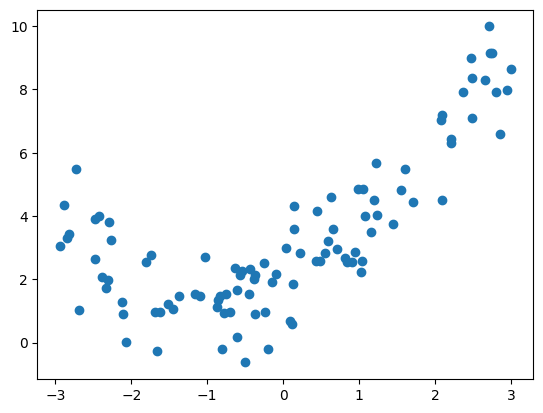

In [86]:
plt.scatter(X, y)

In [87]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-1.16502522]), array([-1.16502522,  1.35728375]))

In [88]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.98075645]), array([[1.00587668, 0.50516915]]))

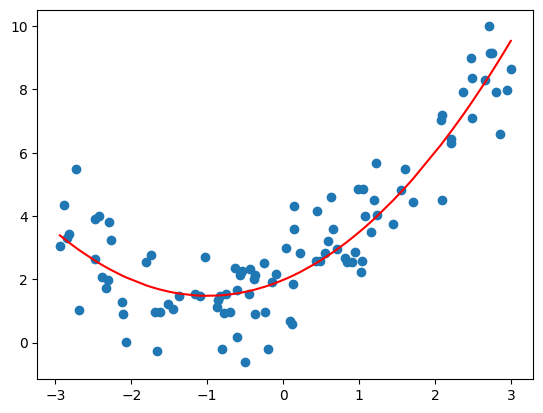

In [89]:
predictions = lin_reg.predict(X_poly)

x_sorted = X.flatten()
predictions_sorted = predictions.flatten()
idx = np.argsort(x_sorted)

plt.scatter(X, y)
plt.plot(x_sorted[idx], predictions[idx], c="red");

**Learning Curve**

In [90]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [91]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errs, val_errs = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errs.append(mean_squared_error(y_train[:m], y_train_pred[:m]))
        val_errs.append(mean_squared_error(y_val[:m], y_val_pred[:m]))
    plt.plot(np.sqrt(train_errs), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errs), "b-", linewidth=3, label="val")
    plt.ylim(0.0, 3.0)
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Training Set Size")

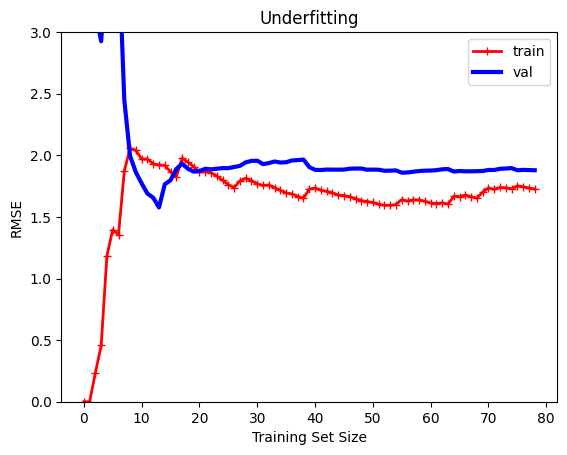

In [99]:
lin_reg = LinearRegression()
plt.title("Underfitting")
plot_learning_curves(lin_reg, X, y)

In [93]:
from sklearn.pipeline import Pipeline

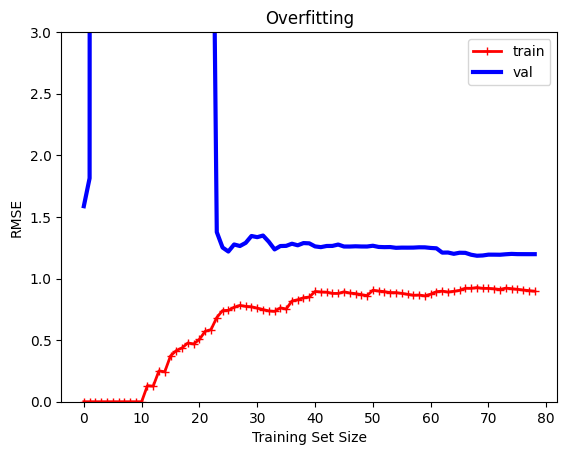

In [95]:
poly_reg = Pipeline([
    ("poly_feats", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])

plt.title("Overfitting")
plot_learning_curves(poly_reg, X, y)

**Regurlarized Linear Models**

*Ridge Regression*
It adds a weighted (by $\alpha$) regularization term, which is a sum of squared parameters.<br>
It keeps them small and as a result they're less prone to producing crazy overfitting patterns.<br>
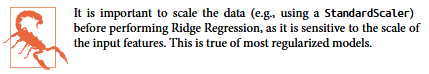

In [107]:
from sklearn.linear_model import Ridge, SGDRegressor

In [103]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)

Ridge(alpha=1, solver='cholesky')

In [106]:
ridge_reg.predict([[1.5]])

array([4.90410638])

In [111]:
# We can also perform it on SGD

sgd_reg = SGDRegressor(penalty="l2", alpha=1)
# .ravel - flattens
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.50858056])

*LASSO Regression*
L1 norm, i.e it adds scaled sum of absolute parameters.<br>
It has an interesting property of setting unimportant features' weights to zero.

In [112]:
from sklearn.linear_model import Lasso

In [113]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.85433645])

*Elastic Net* (oh wow, I didn't know about this one.)<br>
It mixes Ridge and Lasso.<br>
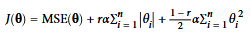

When $r=1$ it is a LASSO, when $r=0$ it is a Ridge.

In [114]:
from sklearn.linear_model import ElasticNet

In [115]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.85457388])

*Early Stopping* (for iterative algorithms)<br>
It stops training as soon as validation loss reaches its minimum and starts to grow.<br>
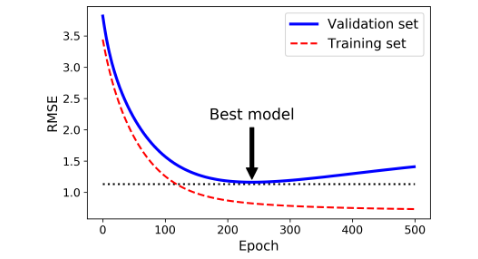

In [125]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# prepare the data
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                        penalty=None, learning_rate="constant", eta0=0.0005)

In [126]:
min_val_error = float("inf")
best_epoch = None
best_model = None

for epoch in range(1_000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    y_val_pred = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

**Logistic Regression**

In [127]:
from sklearn import datasets

In [128]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [130]:
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(int)

In [131]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

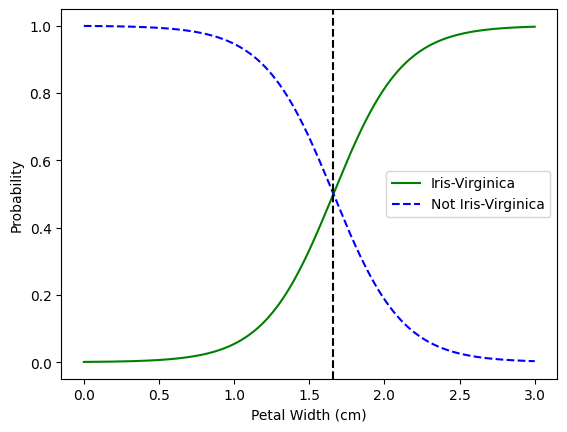

In [147]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")
plt.ylabel("Probability")
plt.xlabel("Petal Width (cm)")
plt.legend()
plt.axvline(x=1.6611, color="black", linestyle="--")

In [148]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

**Softmax (multinomial) Regression**

In [149]:
X = iris["data"][:, (2, 3)]
y = iris["target"]

In [152]:
# durka
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

c:\Users\rayga\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial')

In [153]:
softmax_reg.predict([[5, 2]])

array([2])

In [154]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626373e-07, 5.73689802e-02, 9.42630398e-01]])

Well, that's it.<br>
Finished this chapter with a world ultra mega realnice record, because most of the topics were familiar.